# Analyze RAGIS ensmbles

In [69]:
from datetime import datetime
import numpy as np
import pylab as plt
import pandas as pd
from pathlib import Path
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_mouginot, load_mankoff
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file, to_decimal_year
from pismragis.stats import run_stats

## Some settings

In [70]:
# Root directory
data_dir = Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism")
assert data_dir.exists()
results_dir = "2023_10_tw_ocean_calving_analyis"
o_dir = data_dir / results_dir
o_dir.mkdir(exist_ok=True)
fig_dir = o_dir / "figures"
fig_dir.mkdir(exist_ok=True)
# Number of parallel jobs
n_jobs = 4
# Normalization year (1992 IMBIE)
norm_year = 1992

In [71]:

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

sim_colors = [ "#d73027",  "#4575b4", "#fc8d59", "#91bfdb", "#fee090"]

imbie_color = "#756bb1"
mou_color = "#54278f"

imbie_color = "0.4"
man_color = "0.3"
mou_color = "0.2"

    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

## Load Observations

In [5]:
# imbie = load_imbie(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/imbie_dataset_greenland_dynamics-2020_02_28.xlsx"))
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

mou = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1980)
mou_gis = mou[mou["Basin"] == "GIS"]

mou_1992 = load_mouginot(url=Path("/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"), norm_year=1992)
mou_gis_1992 = mou_1992[mou_1992["Basin"] == "GIS"]

man = load_mankoff()

KeyError: 'SMB (Gt/yr)'

## Make a list of all experiments

In [ ]:
exps = []

# exps.append({
#     "Experiment": "GrIMP",
#     "proj_dir": "2023_10_grimp_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "GRIMP"
# }
# )



# exps.append({
#     "Experiment": "RAGIS",
#     "proj_dir": "2023_10_ragis_ocean_calving_w_posterior_lhs_50",
#     "scalar_dir": "scalar",
#     "processed_dir": "processed",
#     "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
#     "DEM": "RAGIS"
# }
# )

exps.append({
    "Experiment": "GrIMP",
    "proj_dir": "2023_10_grimp_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "GRIMP"
}
)



exps.append({
    "Experiment": "RAGIS",
    "proj_dir": "2023_10_ragis_tw_ocean_calving_w_posterior_lhs_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "RAGIS"
}
)


## Process experiments

In [ ]:
experiments = []

for exp in exps:
    print(f"""Processing {exp["Experiment"]}""")
    print("================================================\n")
    ens_file = data_dir / exp["proj_dir"] / "uq" /f"""{exp["lhs"]}.csv"""
    s_dir = data_dir / exp["proj_dir"] / exp["scalar_dir"]
    scalar_files = sorted(s_dir.glob(f"""ts_gris_g*00m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    processed_path = data_dir / exp["proj_dir"] / exp["processed_dir"]
    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(processed_path.glob(f"""ts_gris_g*00m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc"""))
    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs, norm_year=1980)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Peformace Summary for Experiment GrIMP (16 members)
---------------------------------------------------

processor_hours                   46767.850139
wall_clock_hours                    389.732084
model_years_per_processor_hour        0.012246
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS (18 members)
---------------------------------------------------

processor_hours                   47730.246332
wall_clock_hours                    397.752053
model_years_per_processor_hour        0.013632
dtype: float64
---------------------------------------------------



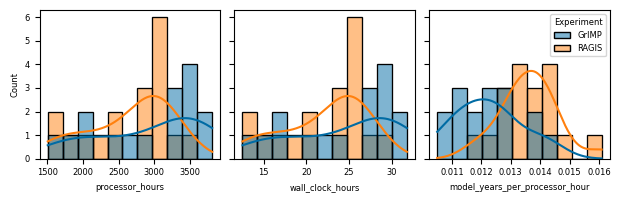

In [70]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

e = experiments[0]["run_stats"]
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
run_stats_file = fig_dir / "run_stats.pdf"
fig.savefig(run_stats_file)

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

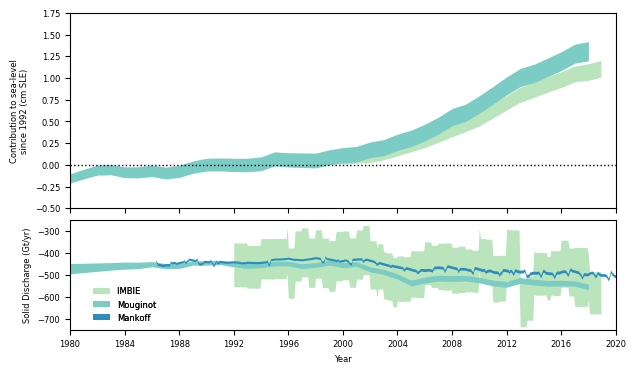

In [71]:
sigma = 1
sigma_mass = 1 
sigma_discharge = 1

imbie_color = "#bae4bc"
mou_color = "#7bccc4"
man_color = "#2b8cbe"

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)

for obs, o, obs_color, obs_loc, obs_alpha  in zip([imbie, mou_gis_1992, man], ["IMBIE ", "Mouginot", "Mankoff"], 
                                       [imbie_color, mou_color, man_color], [(0.5, 0.0), (0.3, 0.0), (0.1, 0.0)], 
                                                  [1, 1, 1]):

    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=f"{sigma}-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)

legend_obs = axs[1].legend(loc="lower center", bbox_to_anchor=obs_loc)
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[1].add_artist(legend_obs)


    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-0.5, 1.75)
axs[1].set_ylim(-750, -250)

# fig.tight_layout()
fig.savefig(fig_dir / "obs_1980-2020.pdf")
fig.savefig(fig_dir / "obs_1980-2020.png", dpi=600)

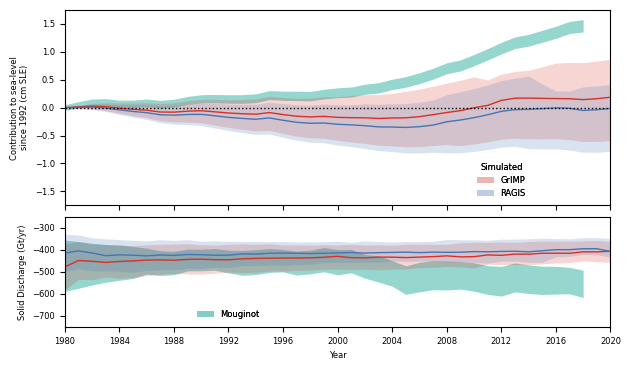

In [72]:
sigma_mass = 1 
sigma_discharge = 5


plot_experiments = experiments

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot"], 
                                       [mou_color], [(0.3, 0.0)], [0.8]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=f"{sigma}-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)


legend_obs = axs[1].legend(loc="lower center", bbox_to_anchor=obs_loc)
legend_obs.get_frame().set_linewidth(0.0)
legend_obs.get_frame().set_alpha(0.0)
axs[1].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.8, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.75, 1.75)
axs[1].set_ylim(-750, -250)

# fig.tight_layout()
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2020.png", dpi=600)

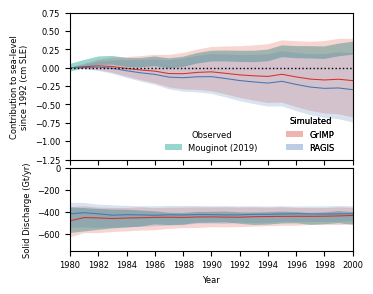

In [73]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 5
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(3.6, 2.8), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.8]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp_scalar_1980-2000.png", dpi=600)

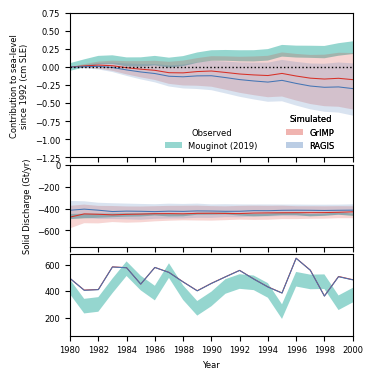

In [74]:
imbie[[discharge_uncertainty_varname]].mean() / mou_gis[[discharge_uncertainty_varname]].mean()
sigma_mass = 1
sigma_discharge = 1
sigma_smb = 1
plot_experiments = [experiments[0], experiments[1]]

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(3.6, 3.8), height_ratios=[16, 9, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.125, top=0.975, left=0.175, right=0.96)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis], ["Mouginot (2019)"], 
                                       [mou_color], [(0.5, 0.0)], [0.8]):
    if mass_varname in obs:
        obs_ci = axs[0].fill_between(obs["Date"], 
                        (obs[mass_varname] + sigma_mass * obs[mass_uncertainty_varname]), 
                        (obs[mass_varname] - sigma_mass * obs[mass_uncertainty_varname]), 
                        ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=o)
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma_discharge * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma_discharge * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma_smb * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma_smb * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)

    legend_obs = axs[0].legend(handles=[obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title="Observed")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(plot_experiments):
    df = exp["data_df"]
    q_16 = df.groupby(by="time").quantile(0.16, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_84 = df.groupby(by="time").quantile(0.84, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=0.75)
    sims_ci = axs[0].fill_between(q_16.index, q_16[mass_varname], 
                        q_84[mass_varname], color=sim_colors[k], alpha=0.2, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_16.index, q_16[discharge_varname], 
                        q_84[discharge_varname], color=sim_colors[k], alpha=0.2, lw=0)
    axs[2].fill_between(q_16.index, q_16[smb_varname], 
                        q_84[smb_varname], color=sim_colors[k], alpha=0.2, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.85, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    

fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.25, 0.75)
axs[1].set_ylim(-750, 0)

axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.pdf")
fig.savefig(fig_dir / "ragis-comp-3_scalar_1980-2000.png", dpi=600)

## Plot sensitivity index

In [ ]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["DEM"]}_{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    o_file = fig_dir / f"{si}_{outfile}"
    fig.savefig(o_file)
    !open o_file

In [ ]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
def resample_ensemble_by_data_o(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, observed_mean, observed_std in zip(
            observed_calib_period["Year"],
            observed_calib_period[m_var],
            observed_calib_period[m_var_std],
        ):
            try:
                observed_std *= fudge_factor
                exp_mean = exp_interp(year)

                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled


In [ ]:
def resample_ensemble_by_data(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, exp_mean in zip(exp_["Year"], exp_[m_var]):
            try:
                observed_mean = observed_interp_mean(year)
                observed_std = observed_interp_std(year) * fudge_factor
                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
                print(i, year, f"{observed_mean:.3f}", f"{observed_std:.3f}", f"{exp_mean:.3f}")

            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled, weights

In [ ]:
uq_df = pd.read_csv("../uq/gris_ragis_calving_simple_lhs_50.csv")

In [ ]:
mou_gis.mean()

In [ ]:
gris_post = pd.read_csv("/Users/andy/base/pism-ragis/uq/X_gris_posterior_1e6_samples_11_2011.csv.gz")

In [ ]:
mankoff = load_mankoff()

man_de_df

In [ ]:
man_df

In [ ]:
man_de.apply?

In [3]:
from typing import Union

In [ ]:
pd.read_csv?

In [60]:
q_84[smb_varname]

time
1980-01-01    497.120902
1981-01-01    407.083288
1982-01-01    411.686467
1983-01-01    583.993831
1984-01-01    577.944241
1985-01-01    454.256268
1986-01-01    580.415980
1987-01-01    542.352730
1988-01-01    470.731750
1989-01-01    402.850087
1990-01-01    458.931345
1991-01-01    509.190835
1992-01-01    557.786464
1993-01-01    492.297445
1994-01-01    432.299174
1995-01-01    385.880257
1996-01-01    650.037533
1997-01-01    559.010908
1998-01-01    362.992960
1999-01-01    510.323071
2000-01-01    486.386670
2001-01-01    550.701121
2002-01-01    433.656493
2003-01-01    450.189177
2004-01-01    435.895347
2005-01-01    433.584121
2006-01-01    348.134175
2007-01-01    326.004664
2008-01-01    377.102663
2009-01-01    308.343739
2010-01-01    222.137109
2011-01-01    234.050795
2012-01-01    186.911498
2013-01-01    470.474569
2014-01-01    390.682985
2015-01-01    363.343605
2016-01-01    350.027492
2017-01-01    511.274775
2018-01-01    439.840216
2019-01-01    287.67

In [72]:
imbie = load_imbie()


In [73]:
imbie

,Year,Rate of ice sheet mass change (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Cumulative ice sheet mass change (Gt),Cumulative ice sheet mass change uncertainty (Gt),Rate of surface mass balance anomaly (Gt/yr),Rate of surface mass balance anomaly uncertainty (Gt/yr),Cumulative surface mass balance anomaly (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Rate of ice discharge anomaly (Gt/yr),Rate of ice discharge anomaly uncertainty (Gt/yr),Cumulative ice discharge anomaly (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),SLE (cm),SLE uncertainty (cm),Date
0,1980.000000,NaN,NaN,NaN,NaN,12.672691,78.709874,1.056058,22.721583,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-01-01 00:00:00.000000000
1,1980.083333,NaN,NaN,NaN,NaN,12.672691,78.709874,2.112115,32.133171,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-01-31 10:29:03.831122155
2,1980.166667,NaN,NaN,NaN,NaN,12.672691,78.709874,3.168173,39.354937,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-03-01 20:58:07.662552845
3,1980.250000,NaN,NaN,NaN,NaN,12.672691,78.709874,4.224230,45.443167,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-04-01 07:27:11.493675000
4,1980.333333,NaN,NaN,NaN,NaN,12.672691,78.709874,5.280288,50.807005,NaN,NaN,NaN,NaN,405.472691,NaN,78.709874,NaN,NaN,NaN,1980-05-01 17:56:15.324797155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2018.583333,-143.8,56.8,-3991.865803,344.868007,45.653071,77.031700,-1961.451876,501.907312,-189.453071,95.70853,-2058.785224,547.081162,438.453071,-582.253071,77.031700,95.70853,1.101204,0.095136,2018-08-02 01:23:26.818472154
464,2018.666667,-143.8,56.8,-4003.849136,345.257579,45.653071,77.031700,-1957.647453,502.399682,-189.453071,95.70853,-2074.572980,547.778369,438.453071,-582.253071,77.031700,95.70853,1.104510,0.095243,2018-09-01 11:52:30.649902847
465,2018.750000,-143.8,56.8,-4015.832470,345.646711,45.653071,77.031700,-1953.843030,502.891569,-189.453071,95.70853,-2090.360736,548.474689,438.453071,-582.253071,77.031700,95.70853,1.107816,0.095351,2018-10-01 22:21:34.481024999
466,2018.833333,-143.8,56.8,-4027.815803,346.035406,45.653071,77.031700,-1950.038608,503.382976,-189.453071,95.70853,-2106.148492,549.170127,438.453071,-582.253071,77.031700,95.70853,1.111122,0.095458,2018-11-01 08:50:38.312147155


In [82]:
def load_mouginot(
    url: str = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx",
    norm_year: float = 1992.0,
):
    """
    Load the Mouginot et al (2019) data set
    """

    df_m = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,P:BJ",
        engine="openpyxl",
    )

    df_u = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,CE:DY",
        engine="openpyxl",
    )

    dfs = []
    for basin, idx in zip(
        ["GIS", "SE", "CE", "NE", "NW", "CW", "SW"],
        [
            [7, 19, 29, 41, 52, 64],
            [6, 18, 28, 40, 51, 63],
            [5, 17, 27, 39, 50, 62],
            [4, 16, 26, 38, 49, 61],
            [3, 15, 25, 37, 48, 60],
            [2, 14, 24, 36, 47, 59],
            [1, 13, 23, 35, 46, 58],
            [0, 12, 22, 34, 45, 57],
        ],
    ):
        d_rate = df_m.iloc[idx[0]]
        smb_rate = df_m.iloc[idx[1]]
        mass_rate = df_m.iloc[idx[2]]
        d_cumulative_anomaly = df_m.iloc[idx[0]]
        smb_cumulative_anomaly = df_m.iloc[idx[1]]
        mass_cumulative = df_m.iloc[idx[2]]

        d_u = df_u.iloc[idx[0]]
        smb_u = df_u.iloc[idx[1]]
        mass_u = df_u.iloc[idx[2]]
        mass_uc = df_u.iloc[idx[3]]

        df = pd.DataFrame(
            data=np.hstack(
                [
                    df_m.columns[1::].values.reshape(-1, 1),
                    mass_cumulative.values[1::].reshape(-1, 1),
                    smb_cumulative_anomaly.values[1::].reshape(-1, 1),
                    -d_cumulative_anomaly.values[1::].reshape(-1, 1),
                    mass_rate.values[1::].reshape(-1, 1),
                    smb_rate.values[1::].reshape(-1, 1),
                    -d_rate.values[1::].reshape(-1, 1),
                    mass_uc.values[1::].reshape(-1, 1),
                    smb_u.values[1::].reshape(-1, 1),
                    d_u.values[1::].reshape(-1, 1),
                ]
            ),
            columns=[
                "Year",
                "Cumulative ice sheet mass change (Gt)",
                "Cumulative surface mass balance anomaly(Gt)",
                "Cumulative ice discharge anomaly (Gt)",
                "Rate of ice sheet mass change (Gt/yr)",
                "Rate of surface mass balance (Gt/yr)",
                "Rate of ice discharge (Gt/yr)",
                "Rate of ice sheet mass change uncertainty (Gt/yr)",
                "Rate of surface mass balance uncertainty (Gt/yr)",
                "Rate of ice discharge uncertainty (Gt/yr)",
            ],
        )
        df = df.astype(
            {
                "Year": float,
                "Cumulative ice sheet mass change (Gt)": float,
                "Cumulative surface mass balance anomaly(Gt)": float,
                "Cumulative ice discharge anomaly (Gt)": float,
                "Rate of ice sheet mass change (Gt/yr)": float,
                "Rate of ice sheet mass change uncertainty (Gt/yr)": float,
                "Rate of surface mass balance (Gt/yr)": float,
                "Rate of surface mass balance uncertainty (Gt/yr)": float,
                "Rate of ice discharge (Gt/yr)": float,
                "Rate of ice discharge uncertainty (Gt/yr)": float,
            }
        )

        df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")

        print(df)
        # Normalize
        for v in [
            "Cumulative ice sheet mass change (Gt)",
        ]:
            df[v] -= df[df["Year"] == norm_year][v].values

        cmSLE = 1.0 / 362.5 / 10.0
        df["SLE (cm)"] = -df["Cumulative ice sheet mass change (Gt)"] * cmSLE
        df["SLE uncertainty (cm)"] = (
            -df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
        )
        df["Basin"] = basin
        dfs.append(df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [83]:
mou = load_mouginot()

      Year  Cumulative ice sheet mass change (Gt)  \
0   1972.0                              48.799409   
1   1973.0                             143.863406   
2   1974.0                              21.112904   
3   1975.0                             -44.280111   
4   1976.0                              37.072155   
5   1977.0                             126.731319   
6   1978.0                              21.051055   
7   1979.0                              20.501280   
8   1980.0                             -40.180091   
9   1981.0                            -182.131191   
10  1982.0                            -165.795477   
11  1983.0                             -21.670843   
12  1984.0                             112.505097   
13  1985.0                               4.426800   
14  1986.0                             -65.880969   
15  1987.0                              95.800627   
16  1988.0                             -70.982266   
17  1989.0                            -176.454

KeyError: 'Cumulative ice sheet mass change uncertainty (Gt)'

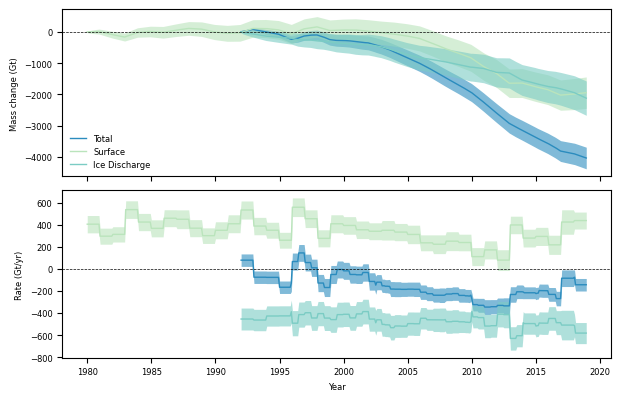

In [146]:
plot_obs(imbie_new)

In [ ]:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for m_var, m_u_var, m_color = zip([mass_varname, smb_varname, d_varname],
                                      [mass_uncertainty_varname, smb_uncertainty_varname, discharge_uncertainty_varname],
                                      [mass_color, smb_color, discharge_color]):
        print("hi")
        


In [84]:
def load_mouginot(
    url: str = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx",
    norm_year: float = 1992.0,
):
    """
    Load the Mouginot et al (2019) data set
    """

    df_m = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,P:BJ",
        engine="openpyxl",
    )

    df_u = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,CE:DY",
        engine="openpyxl",
    )

    dfs = []
    for basin, idx in zip(
        ["GIS", "SE", "CE", "NE", "NW", "CW", "SW"],
        [
            [7, 19, 29, 41, 52, 64],
            [6, 18, 28, 40, 51, 63],
            [5, 17, 27, 39, 50, 62],
            [4, 16, 26, 38, 49, 61],
            [3, 15, 25, 37, 48, 60],
            [2, 14, 24, 36, 47, 59],
            [1, 13, 23, 35, 46, 58],
            [0, 12, 22, 34, 45, 57],
        ],
    ):
        d_rate = df_m.iloc[idx[0]]
        smb_rate = df_m.iloc[idx[1]]
        mass_rate = df_m.iloc[idx[2]]
        mass_cumulative = df_m.iloc[idx[3]]
        d_cumulative_anomaly = df_m.iloc[idx[4]]
        smb_cumulative_anomaly = df_m.iloc[idx[5]]

        d_rate_u = df_u.iloc[idx[0]]
        smb_rate_u = df_u.iloc[idx[1]]
        mass_rate_u = df_u.iloc[idx[2]]
        mass_cumulative_u = df_u.iloc[idx[3]]
        d_cumulative_u = df_u.iloc[idx[4]]
        smb_cumulative_u = df_u.iloc[idx[5]]

        df = pd.DataFrame(
            data=np.hstack(
                [
                    df_m.columns[1::].values.reshape(-1, 1),
                    mass_cumulative.values[1::].reshape(-1, 1),
                    smb_cumulative_anomaly.values[1::].reshape(-1, 1),
                    d_cumulative_anomaly.values[1::].reshape(-1, 1),
                    mass_rate.values[1::].reshape(-1, 1),
                    smb_rate.values[1::].reshape(-1, 1),
                    -d_rate.values[1::].reshape(-1, 1),
                    mass_cumulative_u.values[1::].reshape(-1, 1),
                    smb_cumulative_u.values[1::].reshape(-1, 1),
                    d_cumulative_u.values[1::].reshape(-1, 1),
                    mass_rate_u.values[1::].reshape(-1, 1),
                    smb_rate_u.values[1::].reshape(-1, 1),
                    d_rate_u.values[1::].reshape(-1, 1),
                ]
            ),
            columns=[
                "Year",
                "Cumulative ice sheet mass change (Gt)",
                "Cumulative surface mass balance anomaly (Gt)",
                "Cumulative ice discharge anomaly (Gt)",
                "Cumulative ice sheet mass change uncertainty (Gt)",
                "Cumulative surface mass balance anomaly uncertainty (Gt)",
                "Cumulative ice discharge anomaly uncertainty(Gt)",
                "Rate of ice sheet mass change (Gt/yr)",
                "Rate of surface mass balance (Gt/yr)",
                "Rate of ice discharge (Gt/yr)",
                "Rate of ice sheet mass change uncertainty (Gt/yr)",
                "Rate of surface mass balance uncertainty (Gt/yr)",
                "Rate of ice discharge uncertainty (Gt/yr)",
            ],
        )
        df = df.astype(
            {
                "Year": float,
                "Cumulative ice sheet mass change (Gt)": float,
                "Cumulative surface mass balance anomaly (Gt)": float,
                "Cumulative ice discharge anomaly (Gt)": float,
                "Rate of ice sheet mass change (Gt/yr)": float,
                "Rate of ice sheet mass change uncertainty (Gt/yr)": float,
                "Rate of surface mass balance (Gt/yr)": float,
                "Rate of surface mass balance uncertainty (Gt/yr)": float,
                "Rate of ice discharge (Gt/yr)": float,
                "Rate of ice discharge uncertainty (Gt/yr)": float,
            }
        )

        df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")

        print(df)
        # Normalize
        for v in [
            "Cumulative ice sheet mass change (Gt)",
        ]:
            df[v] -= df[df["Year"] == norm_year][v].values

        cmSLE = 1.0 / 362.5 / 10.0
        df["SLE (cm)"] = -df["Cumulative ice sheet mass change (Gt)"] * cmSLE
        df["SLE uncertainty (cm)"] = (
            -df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
        )
        df["Basin"] = basin
        dfs.append(df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [127]:
def load_mouginot(
    url: str = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx",
    norm_year: float = 1972.0,
):
    """
    Load the Mouginot et al (2019) data set
    """

    df_m = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,P:BJ",
        engine="openpyxl",
    )

    df_u = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,CE:DY",
        engine="openpyxl",
    )

    dfs = []
    for basin, idx in zip(
        ["GIS", "SE", "CE", "NE", "NW", "CW", "SW"],
        [
            [7, 19, 29, 41, 52, 64],
            [6, 18, 28, 40, 51, 63],
            [5, 17, 27, 39, 50, 62],
            [4, 16, 26, 38, 49, 61],
            [3, 15, 25, 37, 48, 60],
            [2, 14, 24, 36, 47, 59],
            [1, 13, 23, 35, 46, 58],
            [0, 12, 22, 34, 45, 57],
        ],
    ):
        d_rate = df_m.iloc[idx[0]]
        smb_rate = df_m.iloc[idx[1]]
        mass_rate = df_m.iloc[idx[2]]
        mass_cumulative = df_m.iloc[idx[3]]
        d_cumulative_anomaly = df_m.iloc[idx[4]]
        smb_cumulative_anomaly = df_m.iloc[idx[5]]

        d_rate_u = df_u.iloc[idx[0]]
        smb_rate_u = df_u.iloc[idx[1]]
        mass_rate_u = df_u.iloc[idx[2]]
        mass_cumulative_u = df_u.iloc[idx[3]]
        d_cumulative_u = df_u.iloc[idx[4]]
        smb_cumulative_u = df_u.iloc[idx[5]]

        df = pd.DataFrame(
            data=np.hstack(
                [
                    df_m.columns[1::].values.reshape(-1, 1),
                    mass_cumulative.values[1::].reshape(-1, 1),
                    smb_cumulative_anomaly.values[1::].reshape(-1, 1),
                    d_cumulative_anomaly.values[1::].reshape(-1, 1),
                    mass_cumulative_u.values[1::].reshape(-1, 1),
                    smb_cumulative_u.values[1::].reshape(-1, 1),
                    d_cumulative_u.values[1::].reshape(-1, 1),
                    mass_rate.values[1::].reshape(-1, 1),
                    smb_rate.values[1::].reshape(-1, 1),
                    -d_rate.values[1::].reshape(-1, 1),
                    mass_rate_u.values[1::].reshape(-1, 1),
                    smb_rate_u.values[1::].reshape(-1, 1),
                    d_rate_u.values[1::].reshape(-1, 1),
                ]
            ),
            columns=[
                "Year",
                "Cumulative ice sheet mass change (Gt)",
                "Cumulative surface mass balance anomaly (Gt)",
                "Cumulative ice discharge anomaly (Gt)",
                "Cumulative ice sheet mass change uncertainty (Gt)",
                "Cumulative surface mass balance anomaly uncertainty (Gt)",
                "Cumulative ice discharge anomaly uncertainty (Gt)",
                "Rate of ice sheet mass change (Gt/yr)",
                "Rate of surface mass balance (Gt/yr)",
                "Rate of ice discharge (Gt/yr)",
                "Rate of ice sheet mass change uncertainty (Gt/yr)",
                "Rate of surface mass balance uncertainty (Gt/yr)",
                "Rate of ice discharge uncertainty (Gt/yr)",
            ],
        )
        df = df.astype(
            {
                "Year": float,
                "Cumulative ice sheet mass change (Gt)": float,
                "Cumulative surface mass balance anomaly (Gt)": float,
                "Cumulative ice discharge anomaly (Gt)": float,
                "Cumulative ice sheet mass change uncertainty (Gt)": float,
                "Cumulative surface mass balance anomaly uncertainty (Gt)": float,
                "Cumulative ice discharge anomaly uncertainty (Gt)": float,
                "Rate of ice sheet mass change (Gt/yr)": float,
                "Rate of ice sheet mass change uncertainty (Gt/yr)": float,
                "Rate of surface mass balance (Gt/yr)": float,
                "Rate of surface mass balance uncertainty (Gt/yr)": float,
                "Rate of ice discharge (Gt/yr)": float,
                "Rate of ice discharge uncertainty (Gt/yr)": float,
            }
        )

        df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")

        # Normalize
        for v in [
            "Cumulative ice sheet mass change (Gt)",
        ]:
            df[v] -= df[df["Year"] == norm_year][v].values

        cmSLE = 1.0 / 362.5 / 10.0
        df["SLE (cm)"] = -df["Cumulative ice sheet mass change (Gt)"] * cmSLE
        df["SLE uncertainty (cm)"] = (
            -df["Cumulative ice sheet mass change uncertainty (Gt)"] * cmSLE
        )
        df["Basin"] = basin
        dfs.append(df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [128]:
mou = load_mouginot()
mou_gis = mou[mou["Basin"] == "GIS"]

In [191]:
def plot_imbie(
    dfs: Union[pd.DataFrame, list[pd.DataFrame]],
    sigma: float = 1,
    title: Union[None, str] = None,
    norm_year: Union[None, float] = None,
    mass_varname: str = "Cumulative ice sheet mass change (Gt)",
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)",
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)",
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)",
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)",
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)",
    mass_rate_varname: str = "Rate of ice sheet mass change (Gt/yr)",
    mass_rate_uncertainty_varname: str = "Rate of ice sheet mass change uncertainty (Gt/yr)",
    smb_rate_varname: str = "Rate of surface mass balance (Gt/yr)",
    smb_rate_uncertainty_varname: str = "Rate of surface mass balance uncertainty (Gt/yr)",
    discharge_rate_varname: str = "Rate of ice discharge (Gt/yr)",
    discharge_rate_uncertainty_varname: str = "Rate of ice discharge uncertainty (Gt/yr)",
    smb_color: str = "#bae4bc",
    discharge_color: str = "#7bccc4",
    mass_color: str = "#2b8cbe",
) -> plt.Figure:
    """Plot IMBIE time series"""
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    
    if not isinstance(dfs, list):
        dfs = [dfs]
    
    for m_var, m_u_var, m_color, m_label in zip(
        [mass_varname, smb_varname, discharge_varname],
        [
            mass_uncertainty_varname,
            smb_uncertainty_varname,
            discharge_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    ):
        if norm_year:
            d_m_var_normed = df[m_var] - df[df["Year"] == norm_year][m_var].values
            df[m_var] = d_m_var_normed

        axs[0].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[0].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    for m_var, m_u_var, m_color, m_label in zip(
        [mass_rate_varname, smb_rate_varname, discharge_rate_varname],
        [
            mass_rate_uncertainty_varname,
            smb_rate_uncertainty_varname,
            discharge_rate_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    ):
        axs[1].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[1].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    axs[0].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[1].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Mass change (Gt)")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Rate (Gt/yr)")
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    if title:
        axs[0].set_title(title)
    fig.tight_layout()

    return fig


NameError: name 'df' is not defined

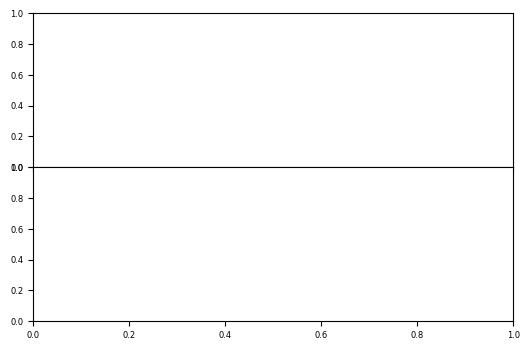

In [192]:
plot_imbie(imbie, title="IMBIE")

/var/folders/5v/ygbxqh8j17l06blqkg6tl26c0000gn/T/ipykernel_77692/1993153727.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[m_var] = d_m_var_normed.copy()


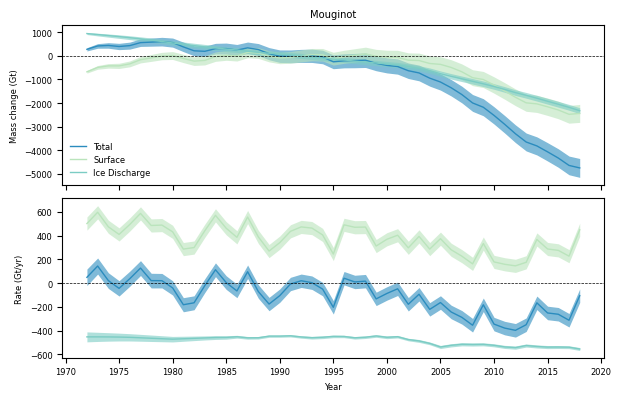

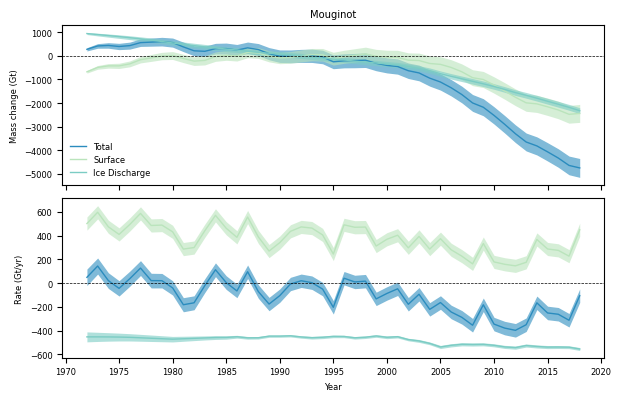

In [185]:
plot_imbie(mou_gis, title="Mouginot", norm_year=1992)

In [186]:
from typing import Union

In [199]:
def plot_observations(
    df: pd.DataFrame,
    sigma: float = 1,
    title: Union[None, str] = None,
    norm_year: Union[None, float] = None,
    mass_varname: str = "Cumulative ice sheet mass change (Gt)",
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)",
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)",
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)",
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)",
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)",
    mass_rate_varname: str = "Rate of ice sheet mass change (Gt/yr)",
    mass_rate_uncertainty_varname: str = "Rate of ice sheet mass change uncertainty (Gt/yr)",
    smb_rate_varname: str = "Rate of surface mass balance (Gt/yr)",
    smb_rate_uncertainty_varname: str = "Rate of surface mass balance uncertainty (Gt/yr)",
    discharge_rate_varname: str = "Rate of ice discharge (Gt/yr)",
    discharge_rate_uncertainty_varname: str = "Rate of ice discharge uncertainty (Gt/yr)",
    smb_color: str = "#bae4bc",
    discharge_color: str = "#7bccc4",
    mass_color: str = "#2b8cbe",
) -> plt.Figure:
    """Plot observation time series"""
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4))
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for m_var, m_u_var, m_color, m_label in zip(
        [mass_varname, smb_varname, discharge_varname],
        [
            mass_uncertainty_varname,
            smb_uncertainty_varname,
            discharge_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    ):
        if norm_year:
            d_m_var_normed = df[m_var] - df[df["Year"] == norm_year][m_var].values
            df[m_var] = d_m_var_normed

        axs[0].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[0].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    for m_var, m_u_var, m_color, m_label in zip(
        [mass_rate_varname, smb_rate_varname, discharge_rate_varname],
        [
            mass_rate_uncertainty_varname,
            smb_rate_uncertainty_varname,
            discharge_rate_uncertainty_varname,
        ],
        [mass_color, smb_color, discharge_color],
        ["Total", "Surface", "Ice Discharge"],
    ):
        axs[1].fill_between(
            df["Date"],
            df[m_var] + sigma * df[m_u_var],
            df[m_var] - sigma * df[m_u_var],
            ls="solid",
            lw=0,
            alpha=0.6,
            color=m_color,
        )
        axs[1].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

    axs[0].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[1].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Mass change (Gt)")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Rate (Gt/yr)")
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)
    if title:
        axs[0].set_title(title)
    fig.tight_layout()

    return fig


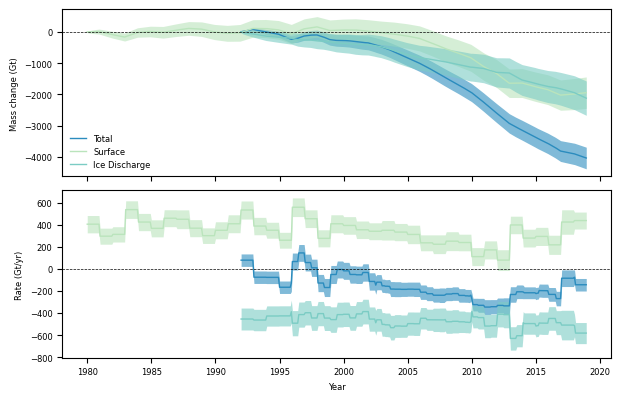

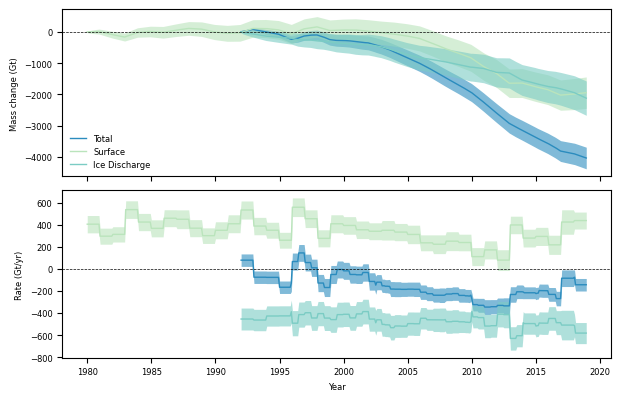

In [200]:
plot_observations(imbie)

In [221]:
def plot_multiple_observations(
    dfs: list[pd.DataFrame],
    sigma: float = 1,
    title: Union[None, str] = None,
    norm_year: Union[None, float] = None,
    mass_varname: str = "Cumulative ice sheet mass change (Gt)",
    mass_uncertainty_varname: str = "Cumulative ice sheet mass change uncertainty (Gt)",
    smb_varname: str = "Cumulative surface mass balance anomaly (Gt)",
    smb_uncertainty_varname: str = "Cumulative surface mass balance anomaly uncertainty (Gt)",
    discharge_varname: str = "Cumulative ice discharge anomaly (Gt)",
    discharge_uncertainty_varname: str = "Cumulative ice discharge anomaly uncertainty (Gt)",
    mass_rate_varname: str = "Rate of ice sheet mass change (Gt/yr)",
    mass_rate_uncertainty_varname: str = "Rate of ice sheet mass change uncertainty (Gt/yr)",
    smb_rate_varname: str = "Rate of surface mass balance (Gt/yr)",
    smb_rate_uncertainty_varname: str = "Rate of surface mass balance uncertainty (Gt/yr)",
    discharge_rate_varname: str = "Rate of ice discharge (Gt/yr)",
    discharge_rate_uncertainty_varname: str = "Rate of ice discharge uncertainty (Gt/yr)",
    smb_colors: list[str] = ["#bae4bc", "#b3cde3", "#fdcc8a"],
    discharge_colors: list[str] = ["#7bccc4", "#8c96c6", "#fc8d59,"],
    mass_colors: list[str] = ["#2b8cbe", "#88419d", "#d7301f"],
) -> plt.Figure:
    """Plot IMBIE time series"""
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 4.2), height_ratios=[16, 9])
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for k, df in enumerate(dfs):
        for m_var, m_u_var, m_color, m_label in zip(
            [mass_varname, smb_varname, discharge_varname],
            [
                mass_uncertainty_varname,
                smb_uncertainty_varname,
                discharge_uncertainty_varname,
            ],
            [mass_colors[k], smb_colors[k], discharge_colors[k]],
            ["Total", "Surface", "Ice Discharge"],
        ):
            if norm_year:
                d_m_var_normed = df[m_var] - df[df["Year"] == norm_year][m_var].values
                df[m_var] = d_m_var_normed

            axs[0].fill_between(
                df["Date"],
                df[m_var] + sigma * df[m_u_var],
                df[m_var] - sigma * df[m_u_var],
                ls="solid",
                lw=0,
                alpha=0.7,
                color=m_color,
            )
            axs[0].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)

        for m_var, m_u_var, m_color, m_label in zip(
            [mass_rate_varname, smb_rate_varname, discharge_rate_varname],
            [
                mass_rate_uncertainty_varname,
                smb_rate_uncertainty_varname,
                discharge_rate_uncertainty_varname,
            ],
            [mass_colors[k], smb_colors[k], discharge_colors[k]],
            ["Total", "Surface", "Ice Discharge"],
        ):
            axs[1].fill_between(
                df["Date"],
                df[m_var] + sigma * df[m_u_var],
                df[m_var] - sigma * df[m_u_var],
                ls="solid",
                lw=0,
                alpha=0.7,
                color=m_color,
            )
            axs[1].plot(df["Date"], df[m_var], lw=1, color=m_color, label=m_label)
    legend = axs[0].legend()
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)

    axs[0].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[1].axhline(0, ls="dashed", color="k", lw=0.5)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Mass change (Gt)")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Rate (Gt/yr)")
    if title:
        axs[0].set_title(title)
    fig.tight_layout()

    return fig


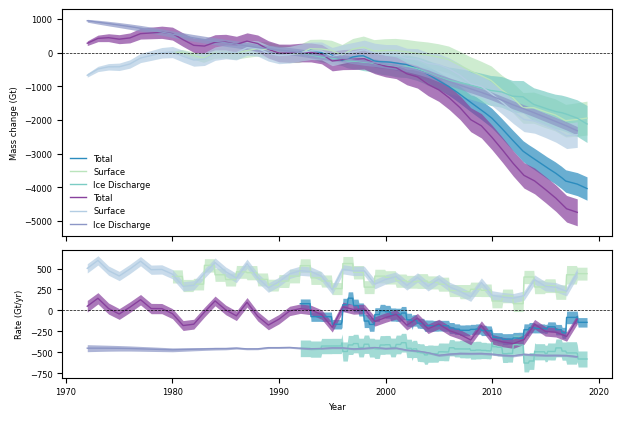

In [222]:
fig = plot_multiple_observations([imbie, mou_gis])
fig.savefig("test.pdf")

In [220]:
!open test.pdf